In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mlflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models import infer_signature
from sklearn.model_selection import GridSearchCV

In [34]:
def preprocessing_data_frame(frame):
    df = frame.copy()
    cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
    num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']
    
    question_dist = df[(df.Year <2021) & (df.Distance < 1100)]
    df = df.drop(question_dist.index)
    # Анализ и очистка данных
    # анализ гистограмм
    question_dist = df[(df.Distance > 1e6)]
    df = df.drop(question_dist.index)
    
    # здравый смысл
    question_engine = df[df["Engine_capacity(cm3)"] < 200]
    df = df.drop(question_engine.index)
    
    # здравый смысл
    question_engine = df[df["Engine_capacity(cm3)"] > 5000]
    df = df.drop(question_engine.index)
    
    # здравый смысл
    question_price = df[(df["Price(euro)"] < 101)]
    df = df.drop(question_price.index)
    
    # анализ гистограмм
    question_price = df[df["Price(euro)"] > 1e5]
    df = df.drop(question_price.index)
    
    #анализ гистограмм
    question_year = df[df.Year < 1971]
    df = df.drop(question_year.index)
    
    df = df.reset_index(drop=True)  # обновим индексы в датафрейме DF. если бы мы прописали drop = False, то была бы еще одна колонка - старые индексы
    # Разделение данных на признаки и целевую переменную
    
    
    # Предварительная обработка категориальных данных
    # Порядковое кодирование. Обучение, трансформация и упаковка в df
    
    ordinal = OrdinalEncoder()
    ordinal.fit(df[cat_columns]);
    Ordinal_encoded = ordinal.transform(df[cat_columns])
    df_ordinal = pd.DataFrame(Ordinal_encoded, columns=cat_columns)
    df[cat_columns] = df_ordinal[cat_columns]
    return df

def scale_frame(frame):
    df = frame.copy()
    X,y = df.drop(columns = ['Price(euro)']), df['Price(euro)']
    scaler = StandardScaler()
    power_trans = PowerTransformer()
    X_scale = scaler.fit_transform(X.values)
    Y_scale = power_trans.fit_transform(y.values.reshape(-1,1))
    return X_scale, Y_scale, power_trans

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_no_dup.csv', delimiter = ',')
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0


In [36]:
df_proc = preprocessing_data_frame(df)
X,Y, power_trans = scale_frame(df_proc)
# разбиваем на тестовую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=0.3,
                                                  random_state=42)

In [37]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [38]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1 ],
      'l1_ratio': [0.001, 0.05, 0.01, 0.2],
      'penalty': ['l1', 'l2', 'elasticnet'],   
 }

with mlflow.start_run():

    lr = SGDRegressor(random_state=42)
    clf = GridSearchCV(lr, params, cv = 5)
    clf.fit(X_train, y_train.reshape(-1))
    best = clf.best_estimator_
    y_pred = best.predict(X_val)
    y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1,1))
    (rmse, mae, r2)  = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)
    alpha = best.alpha
    l1_ratio = best.l1_ratio
    penalty = best.penalty
    eta0 = best.eta0
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_param("penalty", penalty)
    mlflow.log_param("eta0", eta0)
    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    predictions = best.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(best, "model", signature=signature)

🏃 View run clean-fly-198 at: http://127.0.0.1:5000/#/experiments/0/runs/d684608501eb485eb71c5a6c6bf22e78
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [14]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [41]:
import joblib

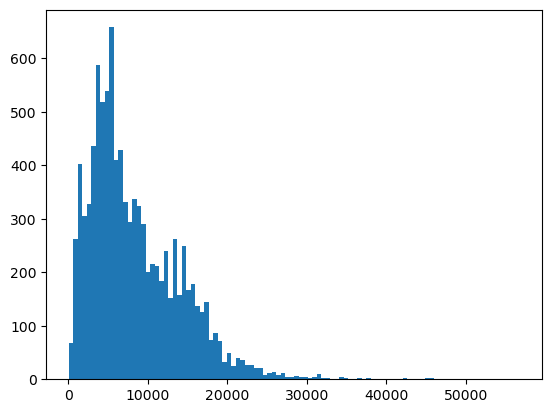

In [53]:
joblib_file = "C:/Users/HUAWEI/mlartifacts/0/c14f5a3133274324bfb2739a856343b7/artifacts/model/model.pkl"
joblib_model = joblib.load(joblib_file)
y = power_trans.inverse_transform(joblib_model.predict(X_val).reshape(-1, 1))
plt.hist(y, 100);

In [43]:
joblib_model

SGDRegressor(random_state=42)